# Machine Learning for String Field Theory

*H. Erbin, R. Finotello, M. Kudrna, M. Schnabl*

## Abstract

In the framework of bosonic **Open String Field Theory** (OSFT), we consider several observables characterised by conformal weight, periodicity of the oscillations and the position of vacua in the potential for various values of truncated mass level.
We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we train the machine learning algorithms on the WZW dataset.
We focus on computing the argument angle of the extrapolated label.

## General Observations

The idea is to improve the finite level predictions and reaching a result as close as possible to the extrapolated label.
We need to find a strategy to evaluate the extrapolated labels with respect to the finite level truncation.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import joblib
import time
from IPython.display import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from analysis import *

import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# set matplot
sns.set()
PREFIX = 'wzw_'
SUFFIX = '_angle'

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# set random seed
RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

In [2]:
# create shortcuts for paths
proot = lambda s: os.path.join('.', s)
pdata = lambda s: os.path.join(proot('data'), s)
pimg  = lambda s: os.path.join(proot('img'), s)
pmet  = lambda s: os.path.join(proot('metrics'), s)
pmod  = lambda s: os.path.join(proot('models'), s)

## Load the Dataset

In [3]:
df = pd.read_csv(pdata('wzw.csv'))
last = 'level_10'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   k            912 non-null    float64
 1   weight       912 non-null    float64
 2   j            912 non-null    float64
 3   m            912 non-null    float64
 4   type_2       912 non-null    int64  
 5   type_4       912 non-null    int64  
 6   level_2      912 non-null    object 
 7   level_3      912 non-null    object 
 8   level_4      912 non-null    object 
 9   level_5      912 non-null    object 
 10  level_6      912 non-null    object 
 11  level_7      912 non-null    object 
 12  level_8      912 non-null    object 
 13  level_9      912 non-null    object 
 14  level_10     912 non-null    object 
 15  level_2_re   912 non-null    float64
 16  level_3_re   912 non-null    float64
 17  level_4_re   912 non-null    float64
 18  level_5_re   912 non-null    float64
 19  level_6_

In [4]:
# convert strings to complex numbers
columns = df.loc[:,df.dtypes == 'object'].columns
for c in columns:
    df[c] = df[c].astype(np.complex)

We need to:

1. define the evaluation metrics,
2. rescale the labels,
3. define the cross-validation strategy,
4. divide into training and test sets,
5. train the algorithms,
6. evaluate each algorithm.

## Evaluation Metric

In general we use the average ratio between the residuals of predicted level and the last finite truncation level:
\begin{equation}
    R(y_{true}, y_{finite}, y_{pred}) = \frac{1}{N} \sum\limits_{i = 1}^N \log_{10}\left| \frac{y_{true}^{(i)} - y_{pred}^{(i)}}{y_{true}^{(i)} - y_{finite}^{(i)}} \right|
\end{equation}
This way a negative result would represent an improvement on finite truncation levels.

## Cross-Validation Strategy

In [5]:
cv = KFold(n_splits=9)

## Train and Test Sets

In [6]:
train, test = train_test_split(df, train_size=0.9, shuffle=True, random_state=RAND)

X_train = train.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_train.to_csv(pdata(PREFIX + 'X_train' + SUFFIX + '.csv'), index=False)
X_train = X_train.drop(columns=['k']).values

X_test  = test.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_test.to_csv(pdata(PREFIX + 'X_test' + SUFFIX + '.csv'), index=False)
X_test = X_test.drop(columns=['k']).values

y_train = train['exp_angle']
y_train.to_csv(pdata(PREFIX + 'y_train' + SUFFIX + '.csv'), index=False)
y_train = y_train.values.reshape(-1,)

y_test  = test['exp_angle']
y_test.to_csv(pdata(PREFIX + 'y_test' + SUFFIX + '.csv'), index=False)
y_test = y_test.values.reshape(-1,)

In [7]:
print(f'Shape of the training set: X = {X_train.shape}, y = {y_train.shape}')
print(f'Shape of the test     set: X = {X_test.shape},  y = {y_test.shape}')

Shape of the training set: X = (820, 12), y = (820,)
Shape of the test     set: X = (92, 12),  y = (92,)


We also need a validation set (10% of the samples) for the neural networks:

In [8]:
train, validation = train_test_split(train, test_size=1/9, shuffle=True, random_state=RAND)

X_train_nn = train.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_train_nn.to_csv(pdata(PREFIX + 'X_train_nn' + SUFFIX + '.csv'), index=False)
X_train_nn = X_train_nn.drop(columns=['k']).values

X_val_nn  = validation.filter(regex='k|weight|type_.*|level_[0-9]*$')
X_val_nn.to_csv(pdata(PREFIX + 'X_val_nn' + SUFFIX + '.csv'), index=False)
X_val_nn = X_val_nn.drop(columns=['k']).values

y_train_nn = train['exp_angle']
y_train_nn.to_csv(pdata(PREFIX + 'y_train_nn' + SUFFIX + '.csv'), index=False)
y_train_nn = y_train_nn.values.reshape(-1,)

y_val_nn  = validation['exp_angle']
y_val_nn.to_csv(pdata(PREFIX + 'y_val_nn' + SUFFIX + '.csv'), index=False)
y_val_nn = y_val_nn.values.reshape(-1,)

y_test_nn = y_test

In [9]:
print(f'Shape of the training   set (ANN): X = {X_train_nn.shape}, y = {y_train_nn.shape}')
print(f'Shape of the validation set (ANN): X = {X_val_nn.shape},  y = {y_val_nn.shape}')

Shape of the training   set (ANN): X = (728, 12), y = (728,)
Shape of the validation set (ANN): X = (92, 12),  y = (92,)


## Extract the Last Truncation Level

In [10]:
last_train    = np.angle(X_train[:,-1]).reshape(-1,) / np.pi
last_train_nn = np.angle(X_train_nn[:,-1]).reshape(-1,) / np.pi
last_val_nn   = np.angle(X_val_nn[:,-1]).reshape(-1,) / np.pi
last_test     = np.angle(X_test[:,-1]).reshape(-1,) / np.pi
last_test_nn  = np.angle(X_test[:,-1]).reshape(-1,) / np.pi

## Apply Fourier Transform to Levels

In [11]:
# compute Fourier transform (for real input)
levels_train    = np.fft.fft(X_train[:,3:], axis=1)
levels_train_nn = np.fft.fft(X_train_nn[:,3:], axis=1)
levels_val_nn   = np.fft.fft(X_val_nn[:,3:], axis=1)
levels_test     = np.fft.fft(X_test[:,3:], axis=1)

# separate modulus and argument
levels_train_mod    = np.abs(levels_train)
levels_train_ang    = np.angle(levels_train) / np.pi
levels_train_nn_mod = np.abs(levels_train_nn)
levels_train_nn_ang = np.angle(levels_train_nn) / np.pi
levels_val_nn_mod   = np.abs(levels_val_nn)
levels_val_nn_ang   = np.angle(levels_val_nn) / np.pi
levels_test_mod     = np.abs(levels_test)
levels_test_ang     = np.angle(levels_test) / np.pi

# concatenate the arrays (the first imaginary part is identically vanishing)
levels_train_conc    = np.c_[levels_train_mod[:,1:], levels_train_ang[:,1:]]
levels_train_nn_conc = np.c_[levels_train_nn_mod[:,1:], levels_train_nn_ang[:,1:]]
levels_val_nn_conc   = np.c_[levels_val_nn_mod[:,1:], levels_val_nn_ang[:,1:]]
levels_test_conc     = np.c_[levels_test_mod[:,1:], levels_test_ang[:,1:]]

# reform the input vectors
X_train    = np.c_[np.real(X_train[:,0:3]), levels_train_conc]
X_train_nn = np.c_[np.real(X_train_nn[:,0:3]), levels_train_nn_conc]
X_val_nn   = np.c_[np.real(X_val_nn[:,0:3]), levels_val_nn_conc]
X_test     = np.c_[np.real(X_test[:,0:3]), levels_test_conc]

## Rescale the Truncation Levels

In [12]:
lev_scaler    = StandardScaler()
lev_scaler_nn = StandardScaler()

# scale the cross-validation levels
levels_train = lev_scaler.fit_transform(X_train[:,3:])
levels_test  = lev_scaler.transform(X_test[:,3:])

# scale the neural network labels
levels_train_nn = lev_scaler_nn.fit_transform(X_train_nn[:,3:])
levels_val_nn   = lev_scaler_nn.transform(X_val_nn[:,3:])
levels_test_nn  = lev_scaler_nn.transform(X_test[:,3:])

# insert the levels back
X_train[:,3:] = levels_train
X_test[:,3:]  = levels_test

X_train_nn[:,3:] = levels_train_nn
X_val_nn[:,3:]   = levels_val_nn
X_test_nn        = X_test
X_test_nn[:,3:]  = levels_test_nn

In [13]:
os.makedirs('./models', exist_ok=True)

In [14]:
# save the scalers
joblib.dump(lev_scaler, pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))
joblib.dump(lev_scaler_nn, pmod(PREFIX + 'levels_nn_scaler' + SUFFIX + '.pkl'))

['./models/wzw_levels_nn_scaler_angle.pkl']

## Training

In [15]:
os.makedirs('./img', exist_ok=True)
os.makedirs('./metrics', exist_ok=True)

### Linear Regression (w/ $\ell_2$ regularisation)

In [16]:
spaces    = {'alpha':         Real(1.0e-8, 1.0e-1, prior='log-uniform'),
             'fit_intercept': Integer(0, 1),
             'normalize':     Integer(0, 1)
            }
estimator = BayesSearchCV(Ridge(tol=1.0e-5, random_state=RAND),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 93.443 seconds.


In [17]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.234 ± 0.003


In [18]:
# save best estimator
joblib.dump(best_estimator, pmod(PREFIX + 'lr' + SUFFIX + '.pkl'))

['./models/wzw_lr_angle.pkl']

In [19]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet(PREFIX + 'lr_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,ridge
alpha,0.088639
fit_intercept,1.000000
normalize,1.000000


In [20]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_lr')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_lr')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'lr_metrics' + SUFFIX + '.csv'))
metrics

,train_lr,test_lr
mean_squared_error,0.223663,0.240663
mean_absolute_error,0.400780,0.424215
r2_score,0.283236,0.161045
residual_ratio,2.764882,2.964969


In [21]:
make_plots(estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_lr')
make_plots(estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_lr')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], prefix=PREFIX, suffix=SUFFIX, name='lr')

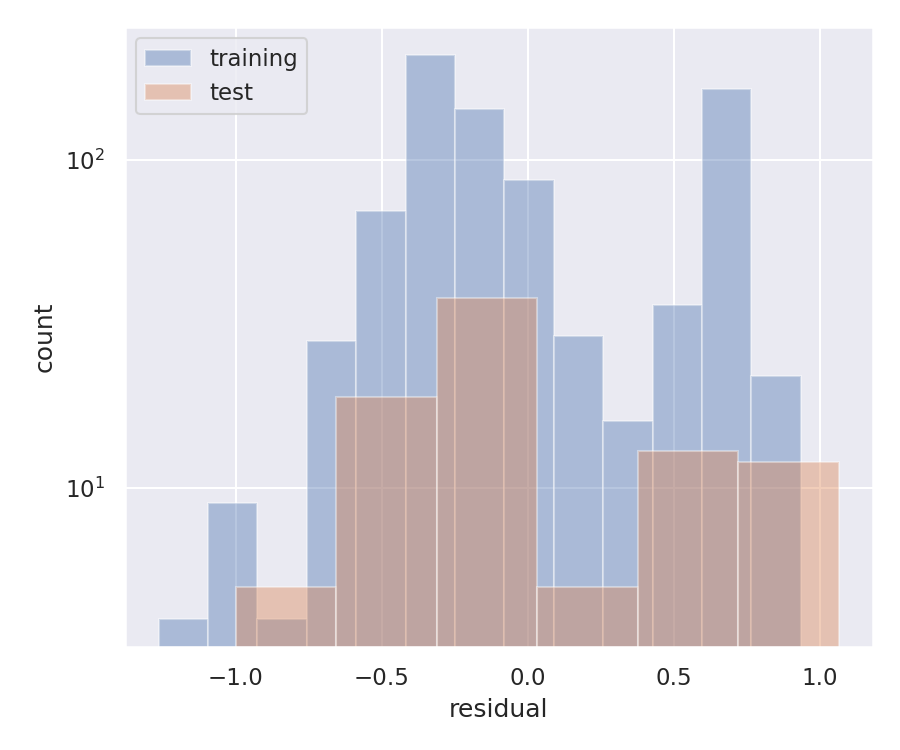

In [22]:
Image(pimg(PREFIX + 'lr_residual_histogram_compare' + SUFFIX + '.png'), width=480)

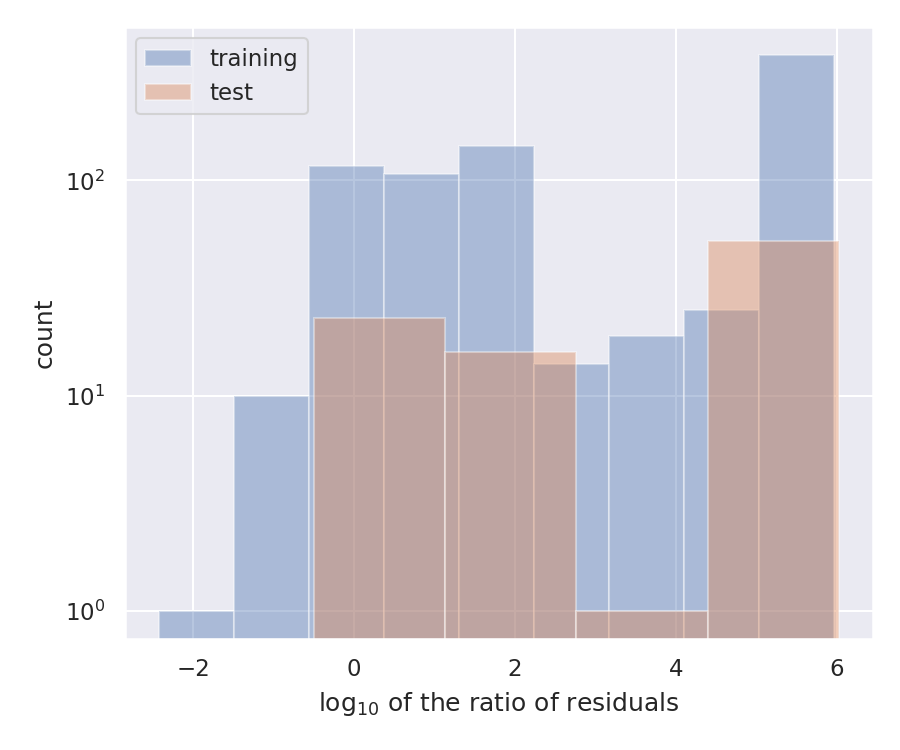

In [23]:
Image(pimg(PREFIX + 'lr_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

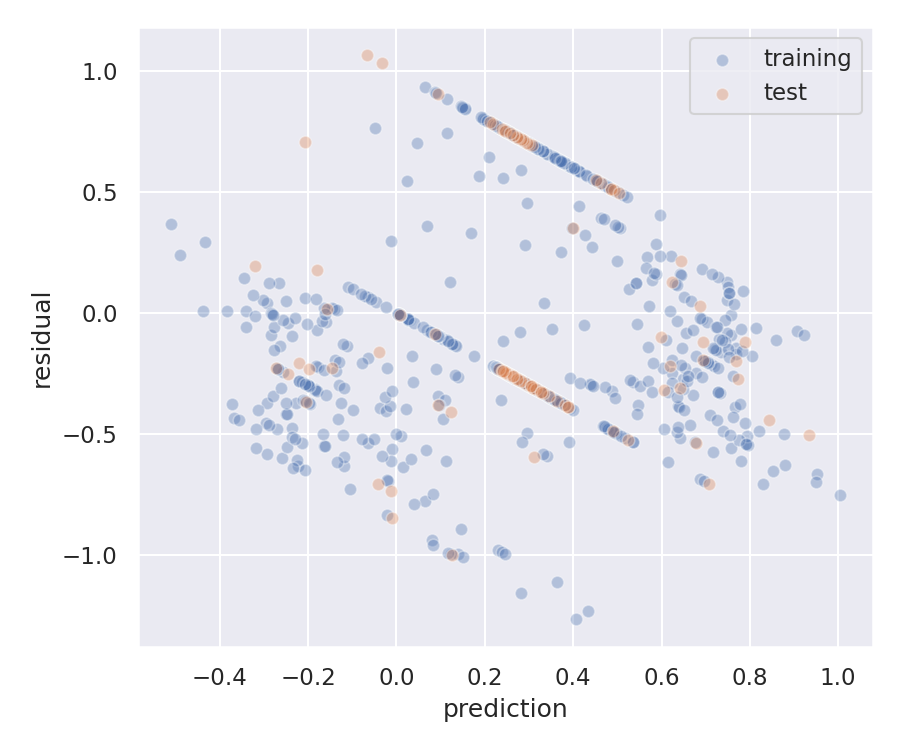

In [24]:
Image(pimg(PREFIX + 'lr_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

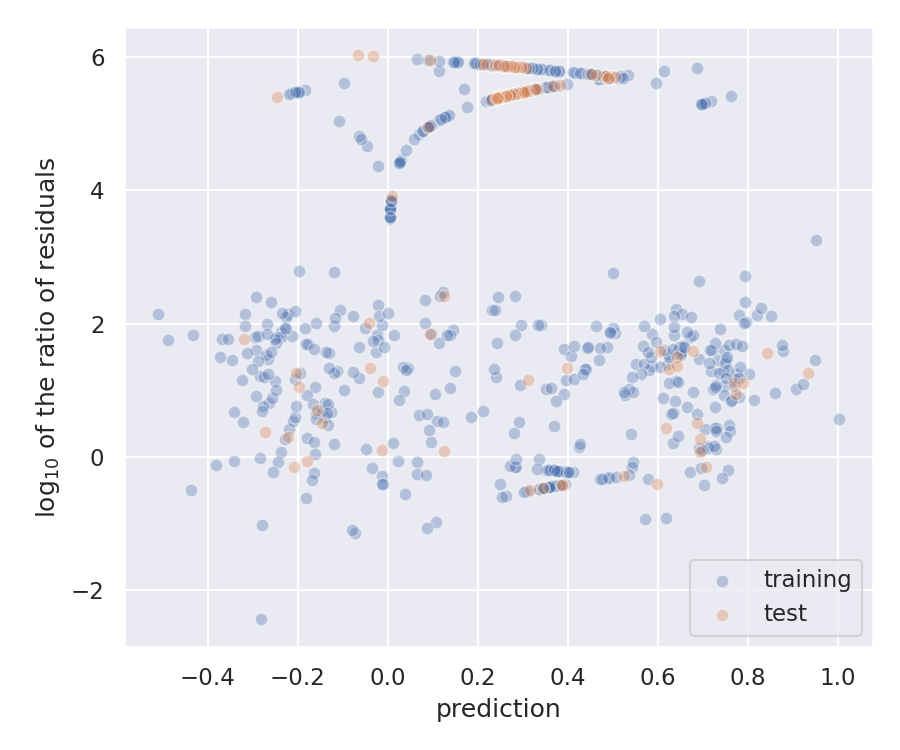

In [25]:
Image(pimg(PREFIX + 'lr_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Support Vector Machine (w/ Gaussian kernel)

In [26]:
spaces    = {'gamma':   Real(1.0e-4, 1.0e1, prior='log-uniform'),
             'C':       Real(1.0e-8, 1.0e-1, prior='log-uniform'),
             'epsilon': Real(1.0e-4, 1.0e-1, prior='log-uniform')
            }
estimator = BayesSearchCV(SVR(kernel='rbf', tol=1.0e-5),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 112.455 seconds.


In [27]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.205 ± 0.004


In [28]:
# save best estimator
joblib.dump(best_estimator, pmod(PREFIX + 'svr' + SUFFIX + '.pkl'))

['./models/wzw_svr_angle.pkl']

In [29]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet(PREFIX + 'svr_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,svr
C,0.10000
epsilon,0.10000
gamma,0.54626


In [30]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_svr')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_svr')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'svr_metrics' + SUFFIX + '.csv'))
metrics

,train_svr,test_svr
mean_squared_error,0.142432,0.200778
mean_absolute_error,0.273081,0.333888
r2_score,0.543553,0.300085
residual_ratio,2.548184,2.752840


In [31]:
make_plots(estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_svr')
make_plots(estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_svr')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], prefix=PREFIX, suffix=SUFFIX, name='svr')

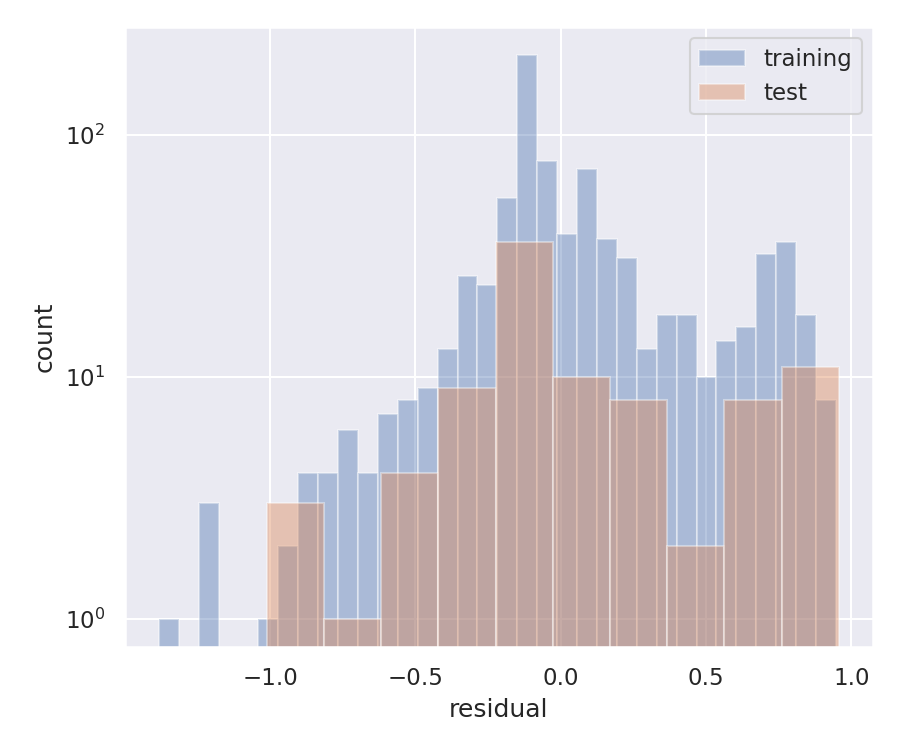

In [32]:
Image(pimg(PREFIX + 'svr_residual_histogram_compare' + SUFFIX + '.png'), width=480)

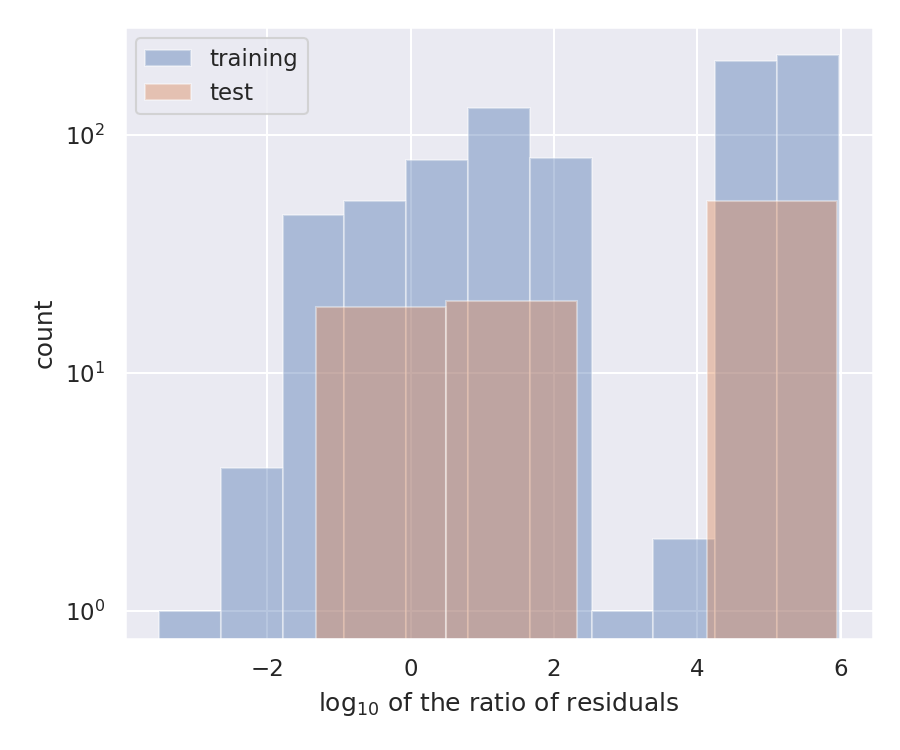

In [33]:
Image(pimg(PREFIX + 'svr_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

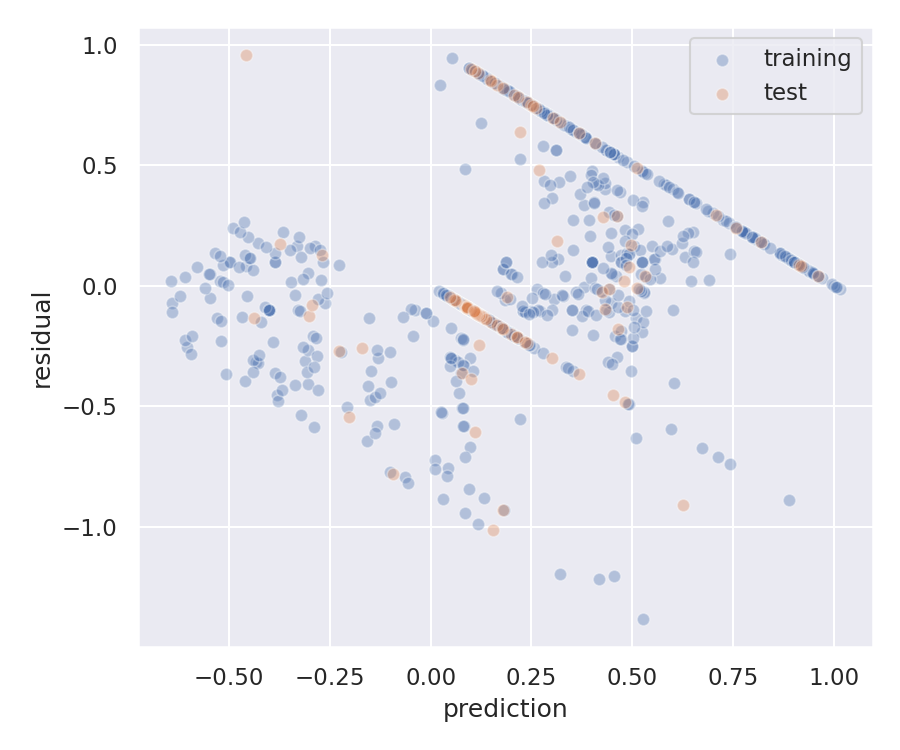

In [34]:
Image(pimg(PREFIX + 'svr_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

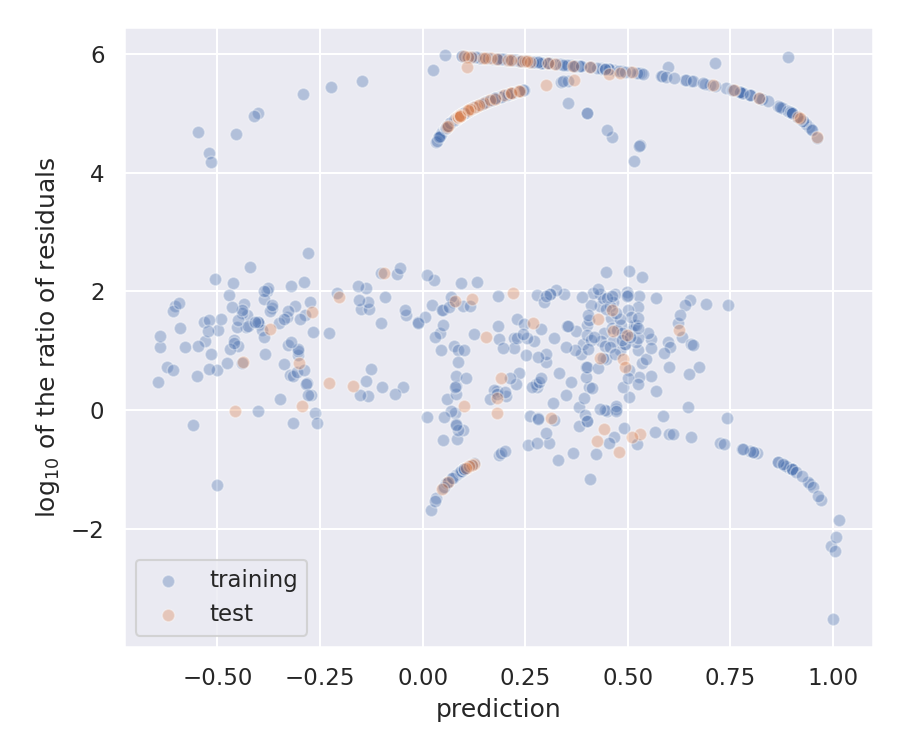

In [35]:
Image(pimg(PREFIX + 'svr_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Gradient Boosted Decision Trees

In [36]:
spaces    = {'num_leaves':       Integer(2, 100),
             'max_depth':        Integer(2, 25),
             'learning_rate':    Real(1e-5, 1e-1, prior='log-uniform'),
             'n_estimators':     Integer(1e1, 2e3, prior='log-uniform'),
             'subsample':        Real(0.5, 0.9),
             'colsample_bytree': Real(0.7, 1.0),
             'min_child_weight': Real(1.0e-3, 1.0e-1, prior='log-uniform'),
             'reg_alpha':        Real(1.0e-5, 1.0e1, prior='log-uniform'),
             'reg_lambda':       Real(1.0e-5, 1.0e1, prior='log-uniform')
            }
estimator = BayesSearchCV(LGBMRegressor(boosting_type='gbdt',
                                        objective='regression',
                                        subsample_freq=1,
                                        n_jobs=-1,
                                        importance_type='gain'
                                       ),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 317.037 seconds.


In [37]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.107 ± 0.003


In [38]:
# save best estimator
joblib.dump(best_estimator, pmod(PREFIX + 'gbdt' + SUFFIX + '.pkl'))

['./models/wzw_gbdt_angle.pkl']

In [39]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet(PREFIX + 'gbdt_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,lgbmregressor
colsample_bytree,1.000000
learning_rate,0.024199
max_depth,25.000000
min_child_weight,0.078837
n_estimators,1327.000000
num_leaves,100.000000
reg_alpha,0.031198
reg_lambda,0.000018
subsample,0.755743


In [40]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_gbdt')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_gbdt')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'gbdt_metrics' + SUFFIX + '.csv'))
metrics

,train_gbdt,test_gbdt
mean_squared_error,0.001007,0.079198
mean_absolute_error,0.018295,0.175598
r2_score,0.996773,0.723914
residual_ratio,1.272803,2.353417


In [41]:
make_plots(estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_gbdt')
make_plots(estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_gbdt')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], prefix=PREFIX, suffix=SUFFIX, name='gbdt')

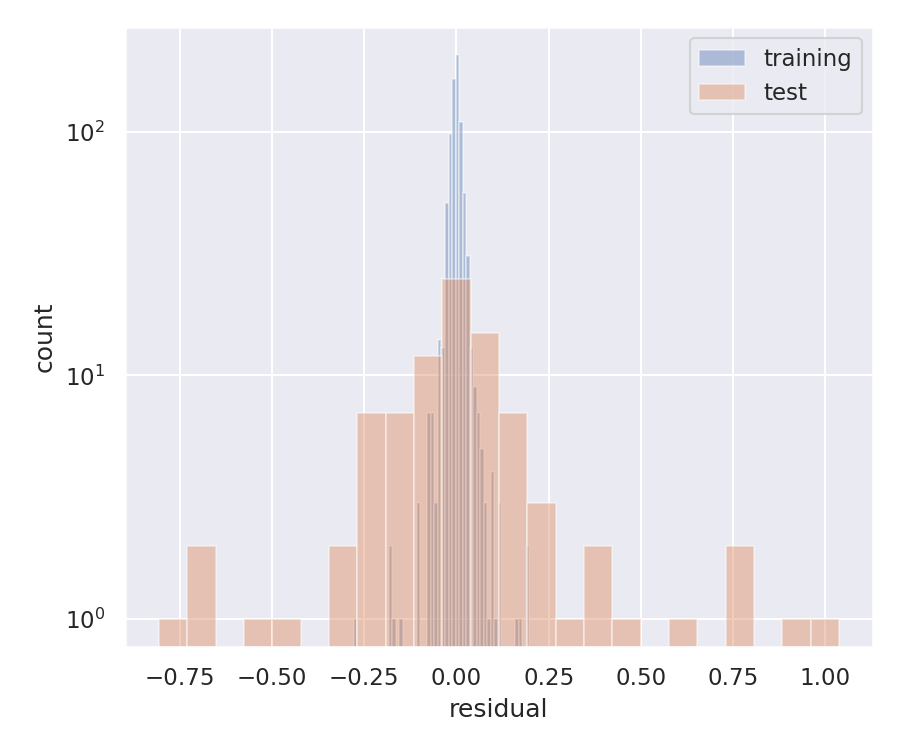

In [42]:
Image(pimg(PREFIX + 'gbdt_residual_histogram_compare' + SUFFIX + '.png'), width=480)

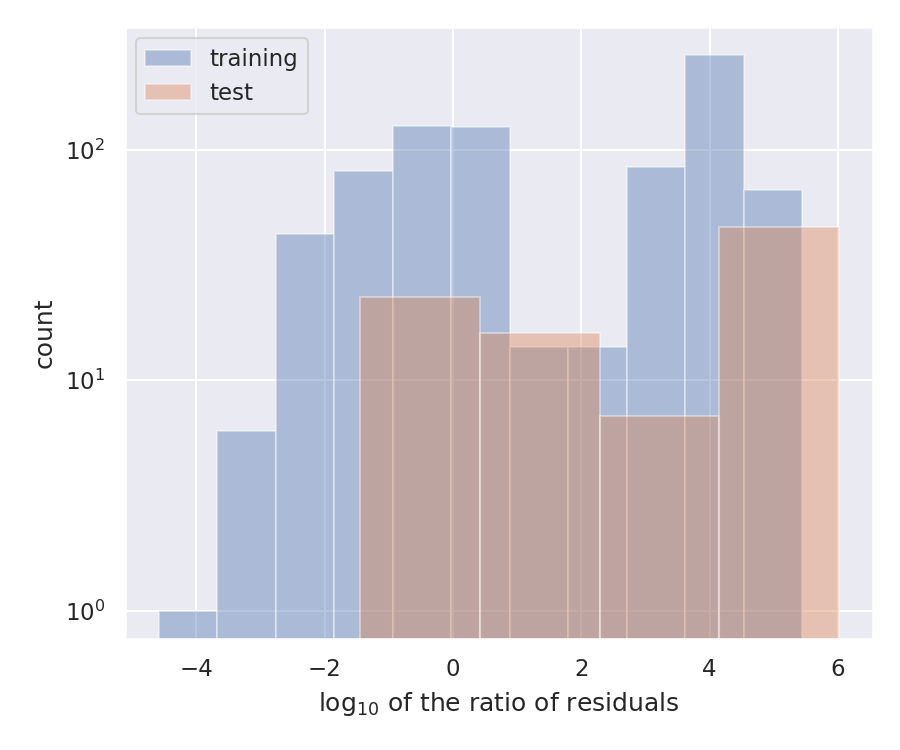

In [43]:
Image(pimg(PREFIX + 'gbdt_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

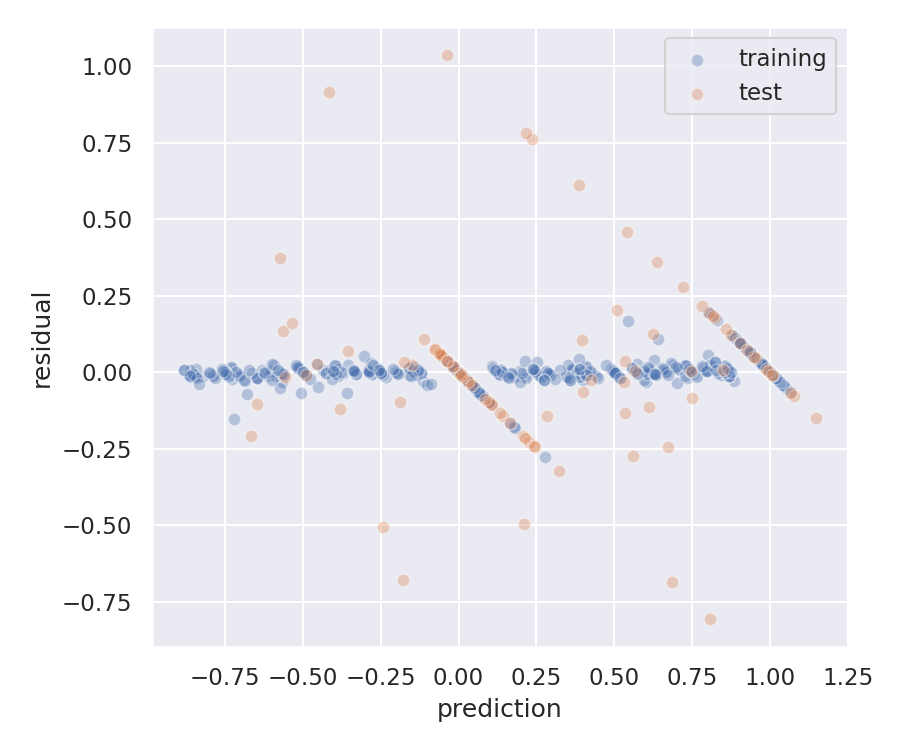

In [44]:
Image(pimg(PREFIX + 'gbdt_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

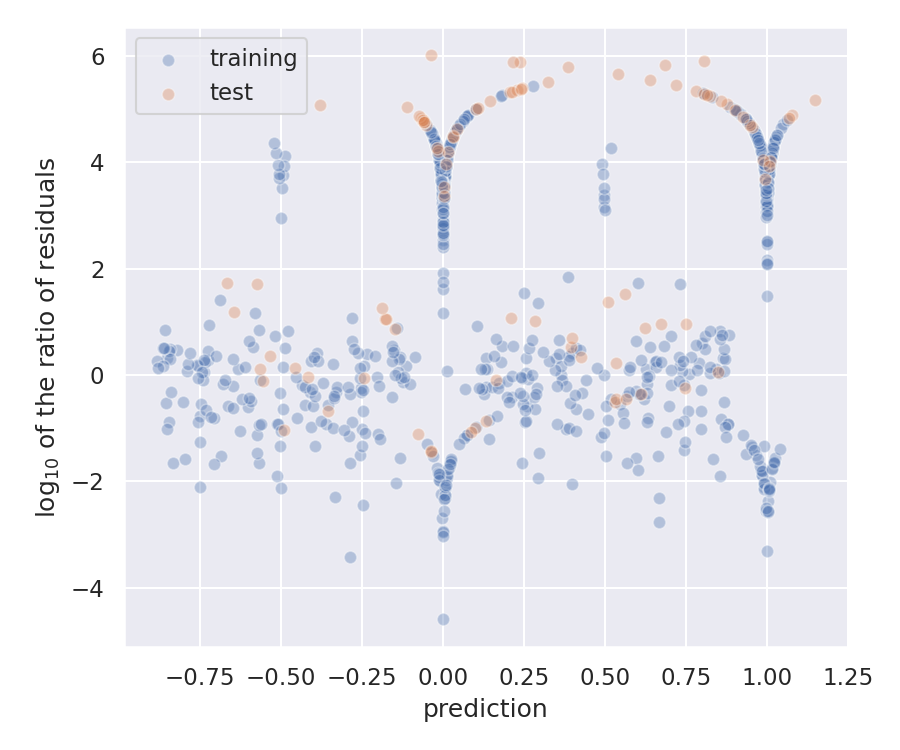

In [45]:
Image(pimg(PREFIX + 'gbdt_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Artificial Neural Network (w/ Keras)

In [46]:
keras.backend.clear_session()

ann = keras.models.Sequential([keras.layers.Input(shape=X_train_nn.shape[1:], name='input'),
                               #####################################################################
                               keras.layers.Dense(50,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.03),
                               #####################################################################
                               keras.layers.Dense(30,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(20,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(20,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(10,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               #####################################################################
                               keras.layers.Dense(10,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               #####################################################################
                               keras.layers.Dense(1, name='exp')
                              ],
                              name='wzw'
                             )
ann.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]
           )
ann.summary()

Model: "wzw"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620     

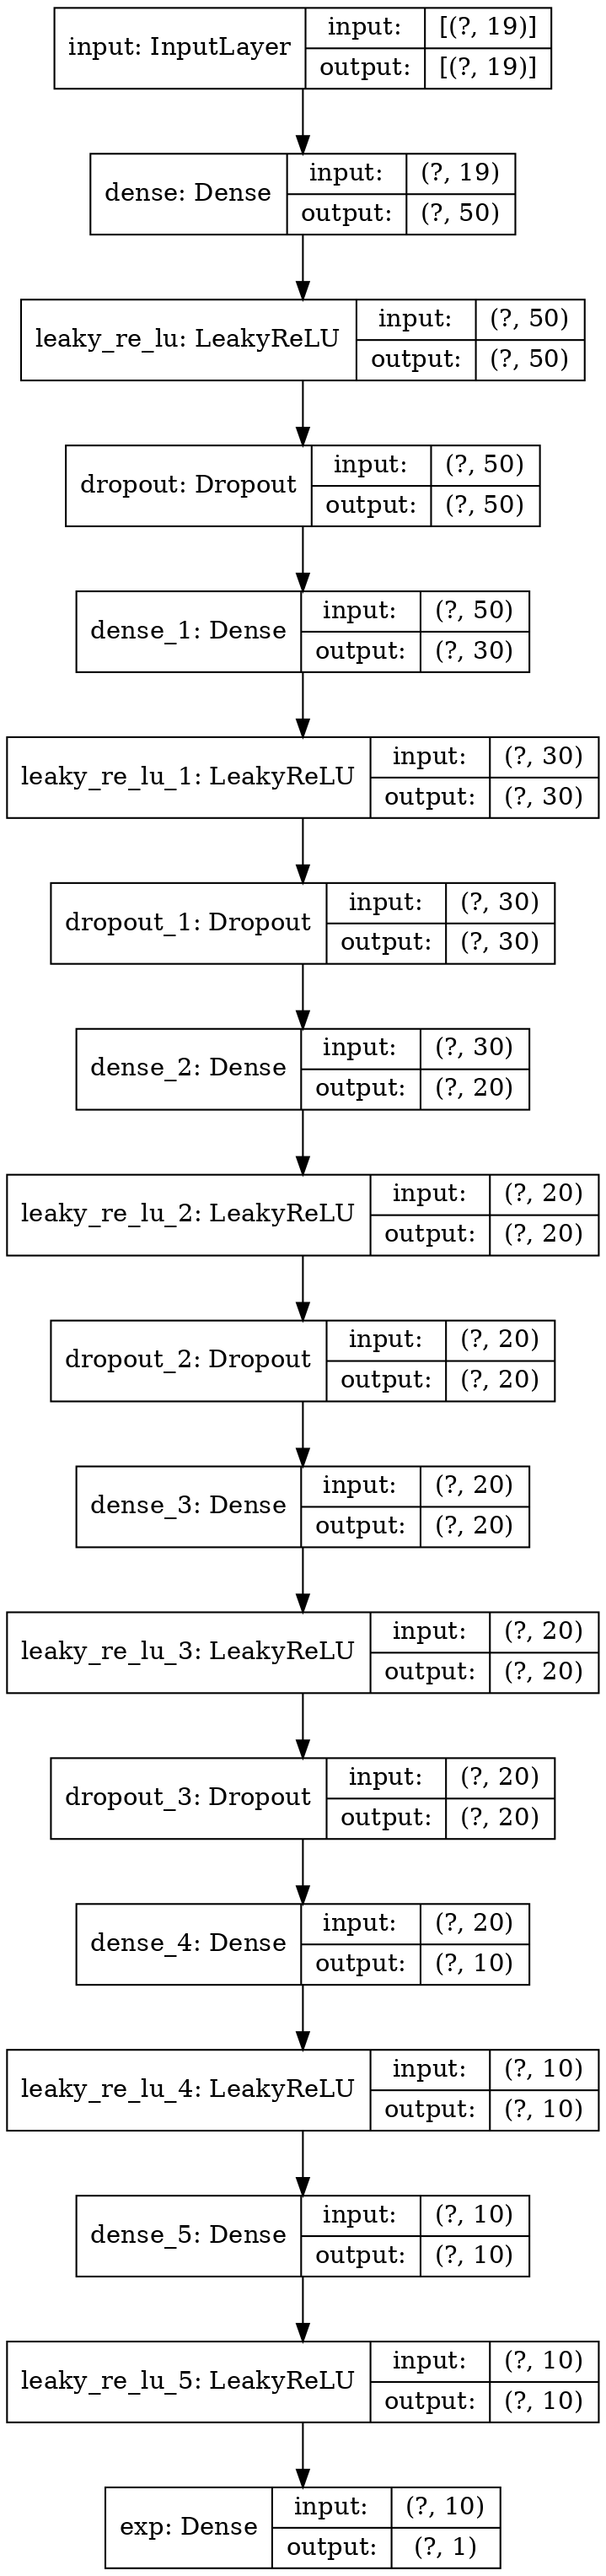

In [47]:
# save figure
ann_dot = keras.utils.model_to_dot(ann,
                                   #rankdir='LR',
                                   rankdir='TB',
                                   show_shapes=True,
                                   dpi=150)
ann_dot.write_pdf(pimg(PREFIX + 'ann_arch' + SUFFIX + '.pdf'))
Image(ann_dot.create_png(), width=320)

In [48]:
def lr_scheduler(epoch, lr):
    '''
    Schedule the learning rate:
    
    Arguments:
        epoch: the current epoch,
        lr:    the current learning rate.
    '''
    if epoch < 1000:
        return lr
    else:
        if lr <= 1.0e-6:
            return lr
        else:
            return lr * tf.math.exp(-1.0e-3)

In [49]:
t = time.time()
ann_history = ann.fit(x=X_train_nn,
                      y=y_train_nn,
                      batch_size=32,
                      epochs=20000,
                      verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=2500, restore_best_weights=True, verbose=0),
                                 keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0),
                                 keras.callbacks.ModelCheckpoint(pmod(PREFIX + 'ann' + SUFFIX + '.h5'), verbose=0, save_best_only=True)
                                ],
                      validation_data=(X_val_nn, y_val_nn)
                     )
t = time.time() - t
print(f'Training took {t:.3f} seconds.')

Training took 192.016 seconds.


In [50]:
# save and display history
ann_history_obj = pd.DataFrame(ann_history.history)
ann_history_obj.to_csv(pmod(PREFIX + 'ann_history' + SUFFIX + '.csv'), index=False)
print(f'No. of epochs: {ann_history_obj.shape[0]:d}')

No. of epochs: 3664


In [51]:
history_plots(ann_history_obj, prefix=PREFIX, suffix=SUFFIX)

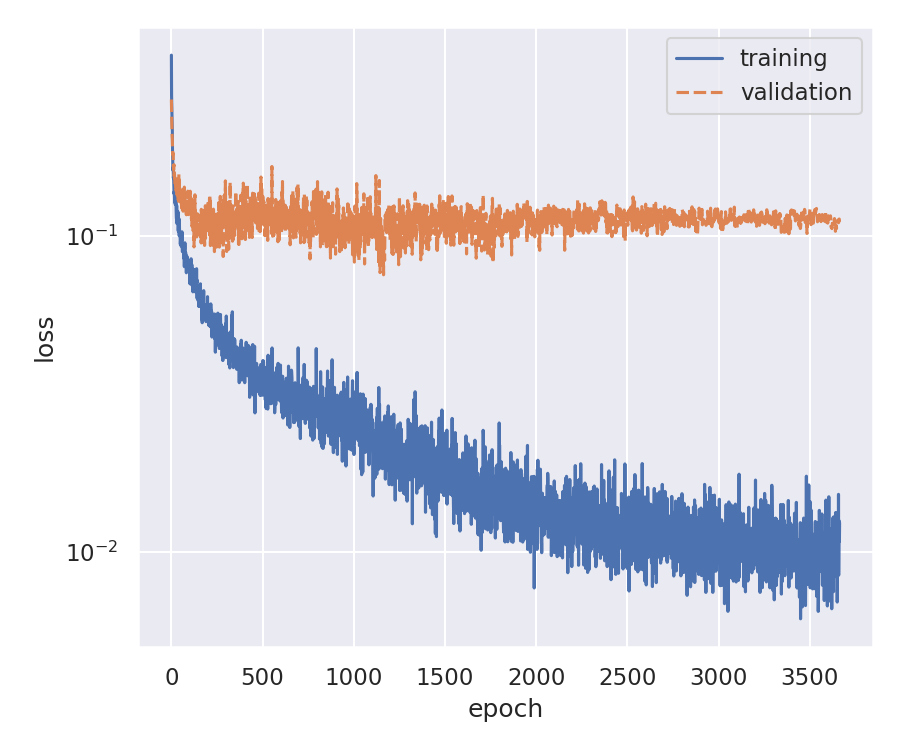

In [52]:
Image(pimg(PREFIX + 'ann_loss' + SUFFIX + '.png'), width=480)

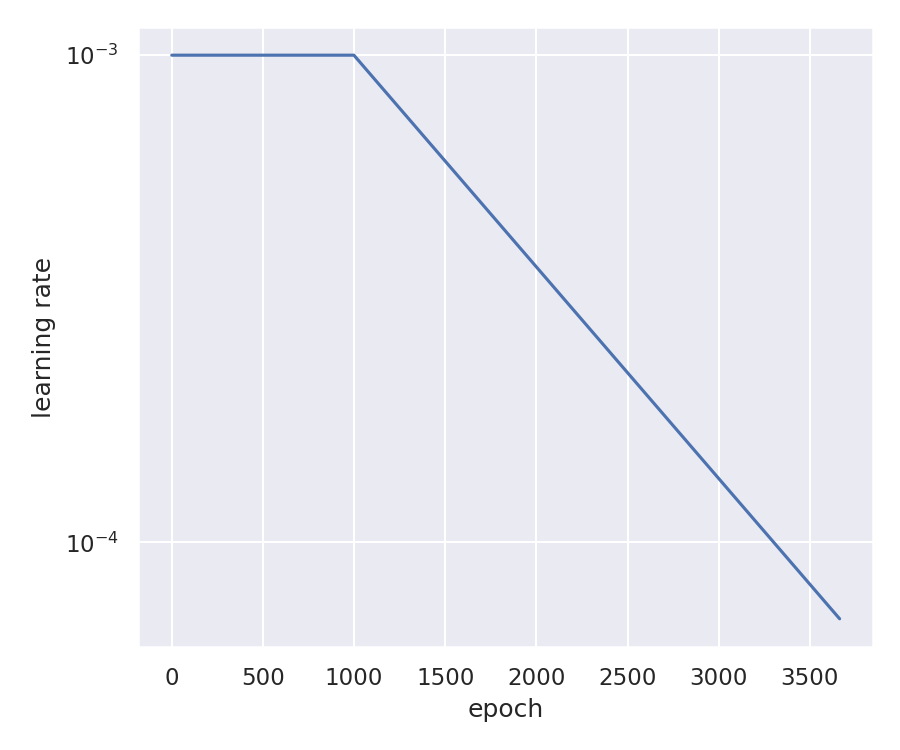

In [53]:
Image(pimg(PREFIX + 'ann_lr' + SUFFIX + '.png'), width=480)

In [54]:
train_metrics = make_predictions(ann, X_train_nn, y_train_nn, last_train_nn, prefix=PREFIX, suffix=SUFFIX, name='train_ann', tensor=True)
val_metrics   = make_predictions(ann, X_val_nn, y_val_nn, last_val_nn, prefix=PREFIX, suffix=SUFFIX, name='val_ann', tensor=True)
test_metrics  = make_predictions(ann, X_test_nn, y_test_nn, last_test_nn, prefix=PREFIX, suffix=SUFFIX, name='test_ann', tensor=True)

# concatenate the prediction results
metrics = pd.concat([train_metrics, val_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'ann_metrics' + SUFFIX + '.csv'))
metrics

,train_ann,val_ann,test_ann
mean_squared_error,0.011309,0.075454,0.135774
mean_absolute_error,0.052184,0.137633,0.190336
r2_score,0.964044,0.740369,0.526690
residual_ratio,2.094101,2.443639,2.668323


In [55]:
make_plots(ann, X_train_nn, y_train_nn, last_train_nn, prefix=PREFIX, suffix=SUFFIX, name='train_ann')
make_plots(ann, X_val_nn, y_val_nn, last_val_nn, prefix=PREFIX, suffix=SUFFIX, name='val_ann')
make_plots(ann, X_test_nn, y_test_nn, last_test_nn, prefix=PREFIX, suffix=SUFFIX, name='test_ann')
compare_plots_val(ann,
                  X_train_nn, y_train_nn, last_train_nn,
                  X_val_nn, y_val_nn, last_val_nn,
                  X_test_nn, y_test_nn, last_test_nn,
                  legend=['training', 'validation', 'test'],
                  prefix=PREFIX,
                  suffix=SUFFIX,
                  name='ann'
                 )

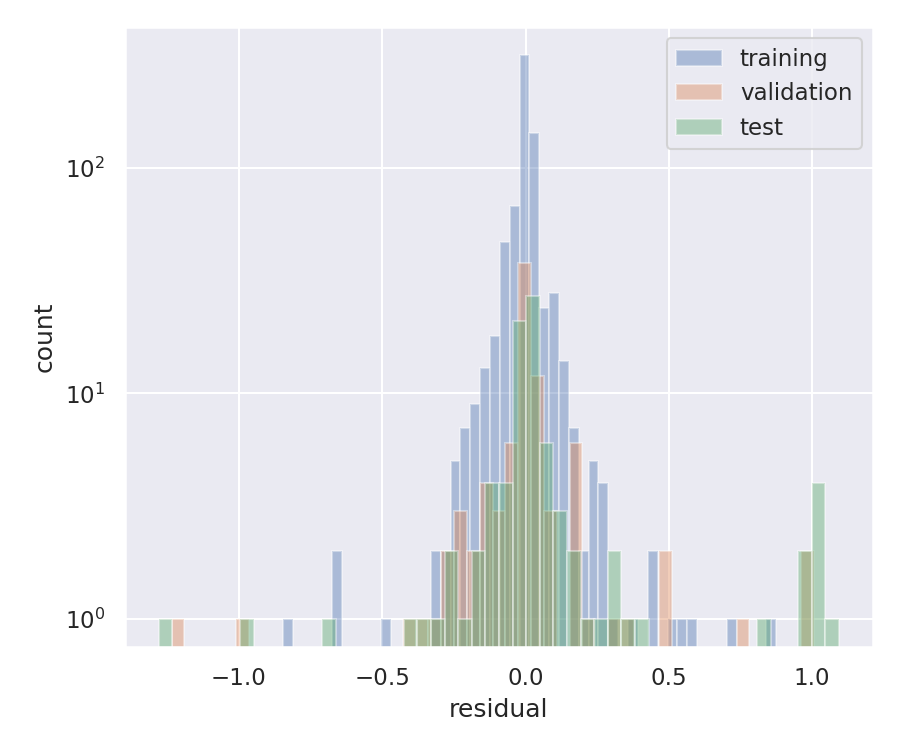

In [56]:
Image(pimg(PREFIX + 'ann_residual_histogram_compare' + SUFFIX + '.png'), width=480)

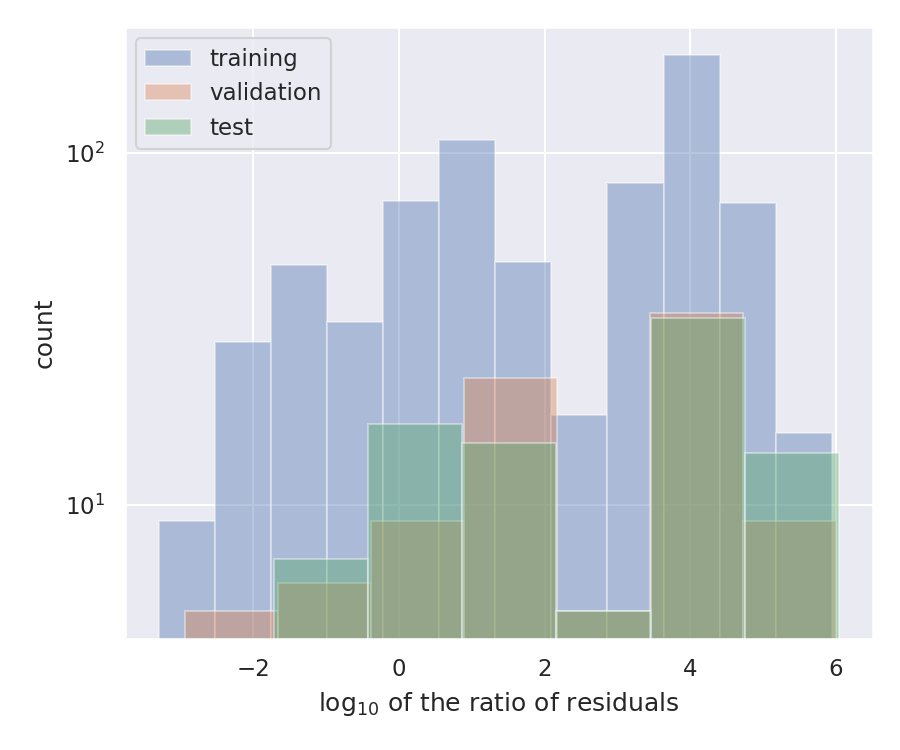

In [57]:
Image(pimg(PREFIX + 'ann_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

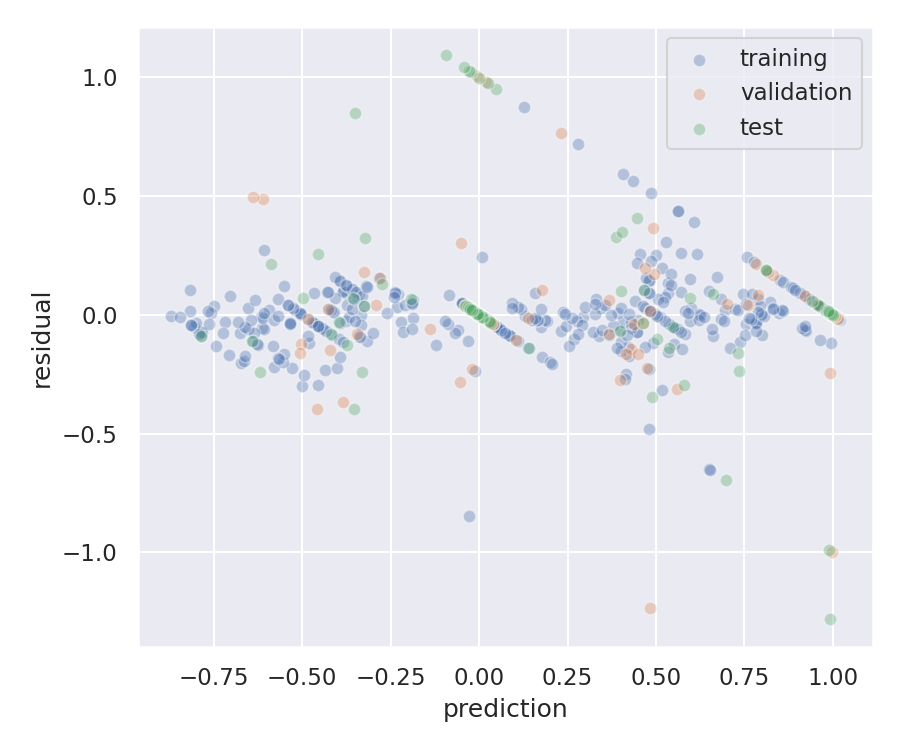

In [58]:
Image(pimg(PREFIX + 'ann_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

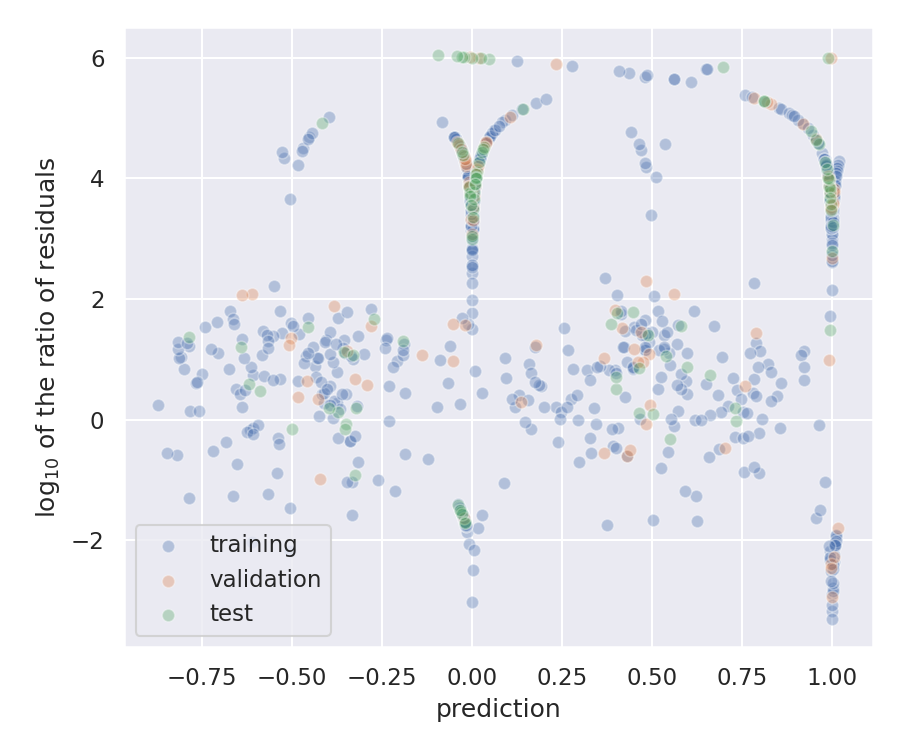

In [59]:
Image(pimg(PREFIX + 'ann_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)